<a href="https://colab.research.google.com/github/GordonYang02/Intro-to-DL/blob/main/homework1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [10/20]  Loss: 0.8056  Train Acc: 0.7068  Val Acc: 0.5335
Epoch [20/20]  Loss: 0.3920  Train Acc: 0.8594  Val Acc: 0.5226

Training finished in 99.20 seconds.


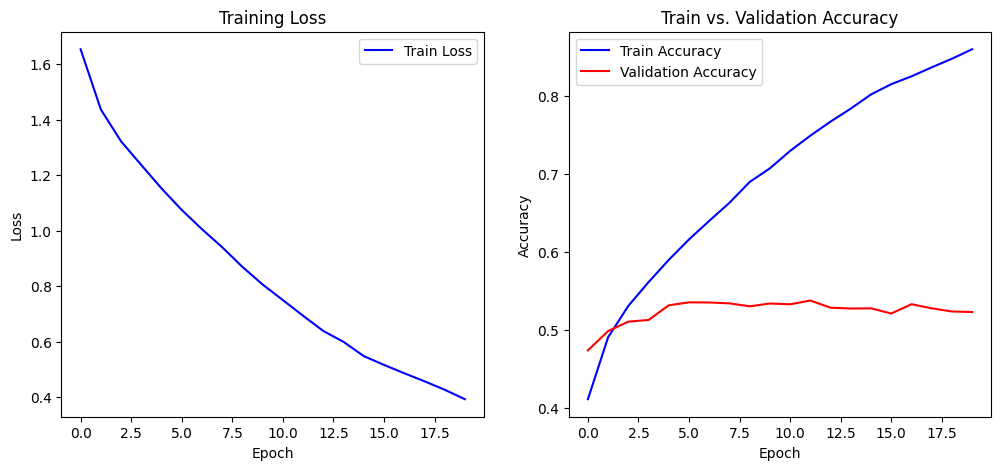

Final Test Accuracy: 0.5226
Precision: 0.5275
Recall: 0.5226
F1 Score: 0.5234


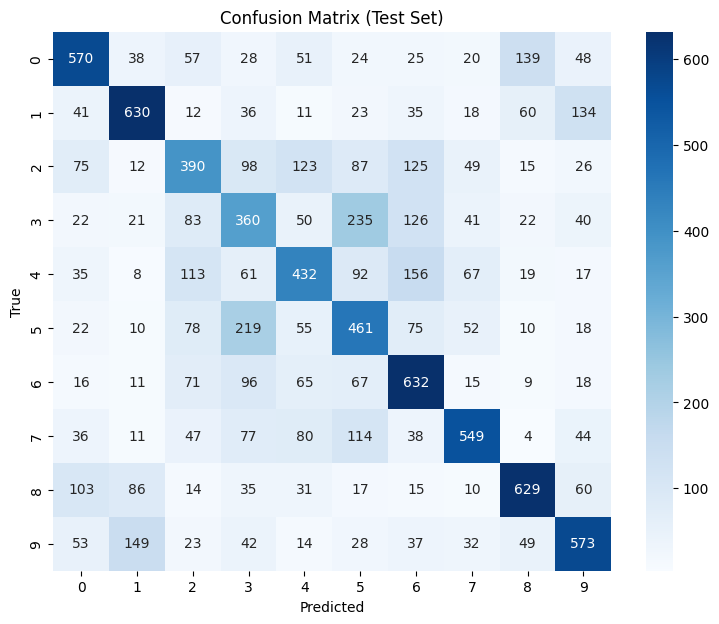

In [9]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# ---------------------------
# Device configuration
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Hyperparameters
# ---------------------------
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 20
HIDDEN_UNITS = 256
NUM_CLASSES = 10
IMAGE_SIZE = 3 * 32 * 32  # Flattened dimension for CIFAR-10 images

# ---------------------------
# Data Loading
# ---------------------------
def load_cifar10_data(batch_size=BATCH_SIZE):
    """
    Loads CIFAR-10 dataset with basic normalization.
    Returns train and test DataLoaders.
    """
    # Basic transform: convert to tensor & normalize
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=trans)
    test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=trans)

    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dl, test_dl

# ---------------------------
# Model Definition
# ---------------------------
class CifarMLP(nn.Module):
    """
    A simple MLP with three hidden layers for CIFAR-10 classification.
    """
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CifarMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ---------------------------
# Training Function
# ---------------------------
def fit_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    """
    Trains the given model and evaluates on val_loader at the end of each epoch.
    Returns training losses, training accuracies, and validation accuracies over epochs.
    """
    history_loss = []
    history_train_acc = []
    history_val_acc = []
    start = time.time()

    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Train accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = epoch_loss / len(train_loader)
        train_acc = correct_train / total_train
        history_loss.append(avg_loss)
        history_train_acc.append(train_acc)

        # Validation accuracy
        model.eval()
        val_correct = 0
        val_count = 0
        with torch.no_grad():
            for imgs_val, labels_val in val_loader:
                imgs_val, labels_val = imgs_val.to(device), labels_val.to(device)
                val_out = model(imgs_val)
                _, val_preds = torch.max(val_out, dim=1)
                val_correct += (val_preds == labels_val).sum().item()
                val_count += labels_val.size(0)
        val_acc = val_correct / val_count
        history_val_acc.append(val_acc)

        # Print progress
        if (ep + 1) % 10 == 0 or (ep + 1) == epochs:
            print(f"Epoch [{ep+1}/{epochs}]  Loss: {avg_loss:.4f}  "
                  f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    elapsed = time.time() - start
    return history_loss, history_train_acc, history_val_acc, elapsed

# ---------------------------
# Main Script
# ---------------------------
def main():
    # Load data
    train_loader, test_loader = load_cifar10_data()

    # Initialize model, criterion, and optimizer
    model = CifarMLP(IMAGE_SIZE, HIDDEN_UNITS, NUM_CLASSES).to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=LR)

    # Train model
    tr_losses, tr_accs, val_accs, train_time = fit_model(
        model, train_loader, test_loader, loss_fn, opt, EPOCHS
    )
    print(f"\nTraining finished in {train_time:.2f} seconds.")

    # Plot training curves
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, tr_losses, label="Train Loss", color="blue")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, tr_accs, label="Train Accuracy", color="blue")
    plt.plot(epochs_range, val_accs, label="Validation Accuracy", color="red")
    plt.title("Train vs. Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Evaluate on test set
    model.eval()
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, predicted = torch.max(logits, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute metrics
    final_acc = accuracy_score(all_true_labels, all_predictions)
    prec, rec, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average="weighted")
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    print(f"Final Test Accuracy: {final_acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(9,7))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

if __name__ == "__main__":
    main()


Using device: cuda
Epoch [10/20] Train Loss: 0.8398 Train Acc: 0.6990 Val Acc: 0.5338
Epoch [20/20] Train Loss: 0.4227 Train Acc: 0.8550 Val Acc: 0.5400

Total Training Time: 105.63 seconds


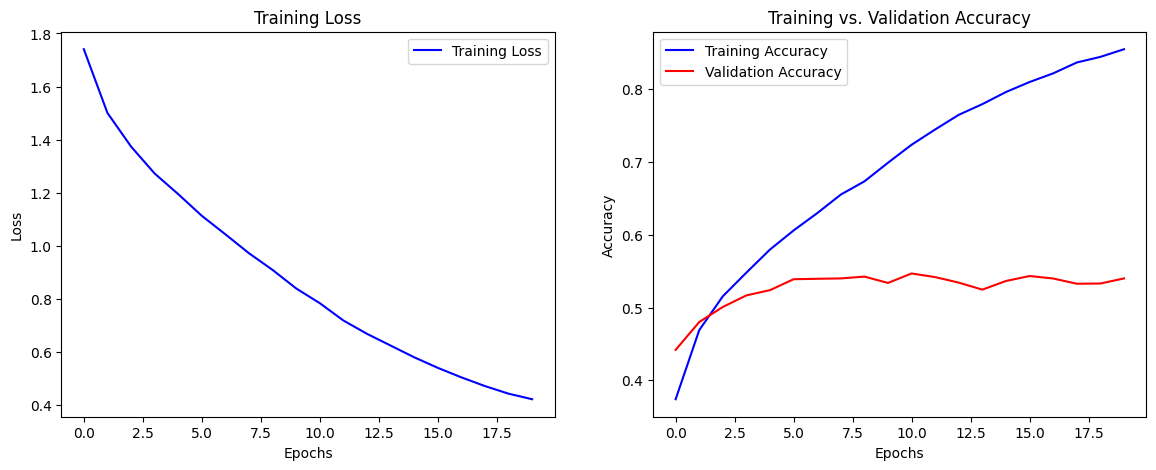


Final Test Accuracy: 0.5400
Precision:          0.5432
Recall:             0.5400
F1 Score:           0.5408


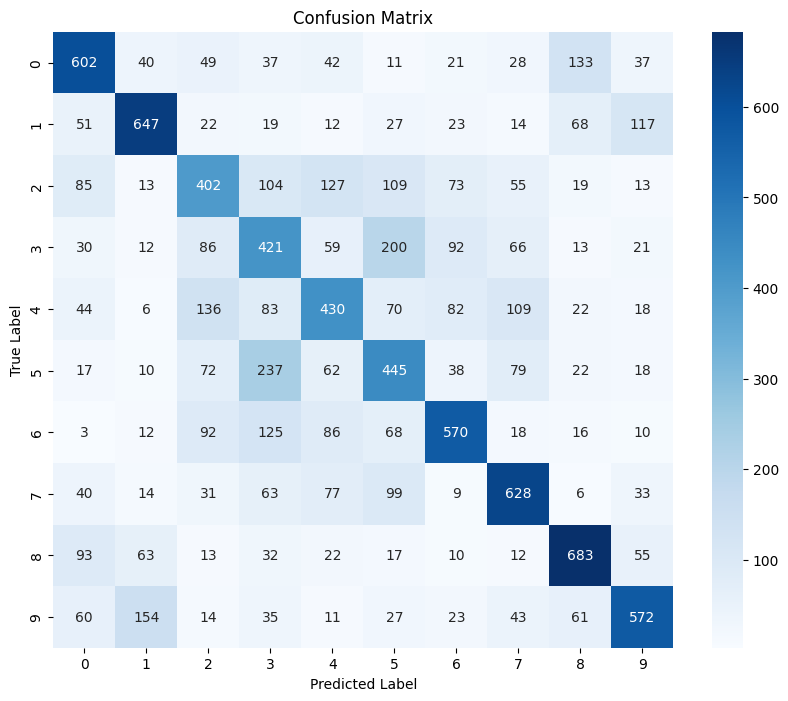

In [10]:
#Problem 1b

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------------------------
# HYPERPARAMETERS
# ---------------------------------------------
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001
HIDDEN_DIM = 512
INPUT_DIM = 3 * 32 * 32  # 32x32 images with 3 color channels
NUM_CLASSES = 10

# ---------------------------------------------
# DATA PREPARATION
# ---------------------------------------------
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # same normalization
])

train_data = torchvision.datasets.CIFAR10(
    root='data',
    train=True,
    transform=transform_pipeline,
    download=True
)

test_data = torchvision.datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform_pipeline,
    download=True
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------------------------
# MODEL DEFINITION
# ---------------------------------------------
class DeepMLP(nn.Module):
    """
    A simple MLP for CIFAR10 classification with multiple hidden layers.
    """
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DeepMLP, self).__init__()

        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = DeepMLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ---------------------------------------------
# TRAINING & VALIDATION FUNCTION
# ---------------------------------------------
def train_and_evaluate(
    net,
    train_dl,
    val_dl,
    criterion,
    optim,
    epochs=NUM_EPOCHS
):
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []
    start_t = time.time()

    for epoch in range(epochs):
        net.train()  # set the model to training mode
        epoch_loss = 0.0
        correct_preds = 0
        total_samples = 0

        # -----------------------------
        # TRAINING LOOP
        # -----------------------------
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backprop
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_train_loss = epoch_loss / len(train_dl)
        train_accuracy = correct_preds / total_samples

        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        # -----------------------------
        # VALIDATION EVALUATION
        # -----------------------------
        net.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images_val, labels_val in val_dl:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                val_outputs = net(images_val)
                _, val_predicted = torch.max(val_outputs, dim=1)
                val_correct += (val_predicted == labels_val).sum().item()
                val_total += labels_val.size(0)
        val_accuracy = val_correct / val_total
        val_acc_history.append(val_accuracy)

        # Print progress every 10 epochs or last epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            print(f"Epoch [{epoch+1}/{epochs}]",
                  f"Train Loss: {avg_train_loss:.4f}",
                  f"Train Acc: {train_accuracy:.4f}",
                  f"Val Acc: {val_accuracy:.4f}")

    total_time = time.time() - start_t
    return train_loss_history, train_acc_history, val_acc_history, total_time

# ---------------------------------------------
# RUN TRAINING
# ---------------------------------------------
train_losses, train_accs, val_accs, total_time = train_and_evaluate(
    net=model,
    train_dl=train_loader,
    val_dl=test_loader,  # Using the test set here as "validation" for simplicity
    criterion=loss_fn,
    optim=optimizer,
    epochs=NUM_EPOCHS
)

print(f"\nTotal Training Time: {total_time:.2f} seconds")

# ---------------------------------------------
# PLOTTING RESULTS
# ---------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot training loss
axs[0].plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot accuracy (train vs test/validation)
axs[1].plot(range(len(train_accs)), train_accs, label='Training Accuracy', color='blue')
axs[1].plot(range(len(val_accs)), val_accs, label='Validation Accuracy', color='red')
axs[1].set_title("Training vs. Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

# ---------------------------------------------
# FINAL EVALUATION ON TEST SET
# ---------------------------------------------
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for images_test, labels_test in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        outputs_test = model(images_test)
        _, preds_test = torch.max(outputs_test, dim=1)
        all_predictions.extend(preds_test.cpu().numpy())
        all_true_labels.extend(labels_test.cpu().numpy())

final_acc = accuracy_score(all_true_labels, all_predictions)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_true_labels, all_predictions, average='weighted'
)

conf_mat = confusion_matrix(all_true_labels, all_predictions)

print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print(f"Precision:          {prec:.4f}")
print(f"Recall:             {rec:.4f}")
print(f"F1 Score:           {f1:.4f}")

# ---------------------------------------------
# CONFUSION MATRIX
# ---------------------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

if __name__ == "__main__":
    main()

Epoch [10/100] - Train Loss: 22280151890765.5039, Val Loss: 26022774833152.0000
Epoch [20/100] - Train Loss: 5369435163882.8623, Val Loss: 5951886721024.0000
Epoch [30/100] - Train Loss: 1612050395136.0000, Val Loss: 2269474717696.0000
Epoch [40/100] - Train Loss: 1159871643347.3762, Val Loss: 2003838566400.0000
Epoch [50/100] - Train Loss: 1061437311859.0825, Val Loss: 1930512302080.0000
Epoch [60/100] - Train Loss: 1010870740625.6146, Val Loss: 1863248379904.0000
Epoch [70/100] - Train Loss: 982247395008.5872, Val Loss: 1846323314688.0000
Epoch [80/100] - Train Loss: 960160435547.5963, Val Loss: 1797276303360.0000
Epoch [90/100] - Train Loss: 942287230243.2294, Val Loss: 1779190857728.0000
Epoch [100/100] - Train Loss: 929020088733.3578, Val Loss: 1766024413184.0000

Training completed in 10.26 seconds.


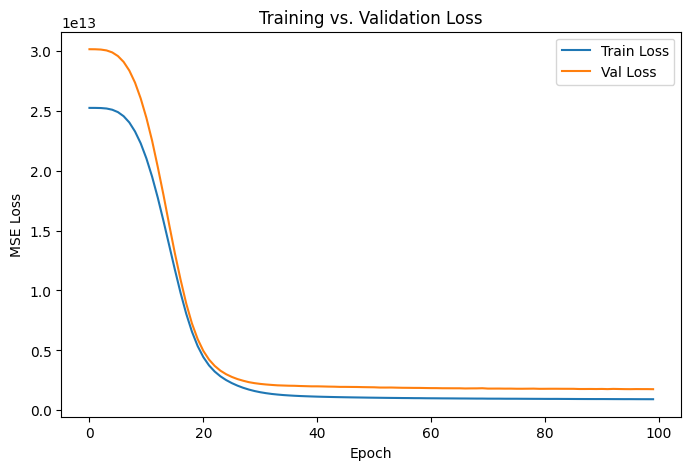


Final Model Results:
MSE  = 1766024675328.00
RMSE = 1328918.62
R^2  = 0.6506


In [12]:
#Problem 2a

import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -----------------------------------------
# Check if CUDA is available
# -----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------
# 1. Load and Prepare Data
# -----------------------------------------
def fetch_housing_data(url):
    """Fetches the housing data from a CSV URL."""
    return pd.read_csv(url)

def convert_categorical(df, cat_cols):
    """Converts 'yes/no' categorical columns into 1/0."""
    for col in cat_cols:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    return df

def prepare_data(df):
    """Splits the data into features X and target y, then returns train/test sets."""
    X = df[['area', 'bedrooms', 'bathrooms', 'stories',
            'mainroad', 'guestroom', 'basement', 'hotwaterheating',
            'airconditioning', 'parking', 'prefarea']]
    y = df['price']

    # Train/test split: 80% train, 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train.values, y_test.values

# -----------------------------------------
# 2. Build the MLP Model
# -----------------------------------------
class HouseMLP(nn.Module):
    """A simple 3-hidden-layer MLP for housing price regression."""
    def __init__(self, input_dim):
        super(HouseMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # output is a single price
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------------------
# 3. Training Function
# -----------------------------------------
def train_regressor(model, loader_train, X_val, y_val, epochs, lr):
    """
    Trains the model and evaluates validation loss each epoch.
    Returns lists of training and validation losses over epochs.
    """
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []
    val_loss_list = []

    start_t = time.time()
    for ep in range(epochs):
        model.train()
        running_loss = 0.0

        for features, targets in loader_train:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = model(features)
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(loader_train)
        train_loss_list.append(epoch_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = loss_fn(val_preds, y_val).item()
        val_loss_list.append(val_loss)

        if (ep + 1) % 10 == 0 or ep == epochs - 1:
            print(f"Epoch [{ep+1}/{epochs}] - "
                  f"Train Loss: {epoch_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}")

    total_time = time.time() - start_t
    print(f"\nTraining completed in {total_time:.2f} seconds.")
    return train_loss_list, val_loss_list, total_time

# -----------------------------------------
# 4. Main Script
# -----------------------------------------
def main():
    # URL to the housing CSV
    data_url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv"

    # Load and prepare data
    df = fetch_housing_data(data_url)
    cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                'airconditioning', 'prefarea']
    df = convert_categorical(df, cat_cols)

    X_train_sc, X_test_sc, y_train_arr, y_test_arr = prepare_data(df)

    # Convert to PyTorch tensors
    X_train_t = torch.tensor(X_train_sc, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train_arr, dtype=torch.float32).view(-1, 1).to(device)
    X_test_t = torch.tensor(X_test_sc, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_arr, dtype=torch.float32).view(-1, 1).to(device)

    # Create DataLoader
    batch_size = 4
    ds_train = TensorDataset(X_train_t, y_train_t)
    ds_test = TensorDataset(X_test_t, y_test_t)
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

    # Define model
    input_dim = X_train_sc.shape[1]
    model = HouseMLP(input_dim).to(device)

    # Train
    epochs = 100
    lr = 0.001
    train_loss, val_loss, t_time = train_regressor(model, train_loader, X_test_t, y_test_t, epochs, lr)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(epochs), train_loss, label="Train Loss")
    plt.plot(range(epochs), val_loss, label="Val Loss")
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    # Evaluate final model
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test_t).cpu().numpy().flatten()
        actual_test = y_test_t.cpu().numpy().flatten()

    # Compute metrics
    mse = np.mean((preds_test - actual_test)**2)
    rmse = np.sqrt(mse)
    ss_total = np.sum((actual_test - np.mean(actual_test))**2)
    ss_res = np.sum((actual_test - preds_test)**2)
    r2 = 1 - (ss_res / ss_total)

    print("\nFinal Model Results:")
    print(f"MSE  = {mse:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R^2  = {r2:.4f}")

if __name__ == "__main__":
    main()


Running on device: cuda
Epoch [10/100] -> Train Loss: 20973376802026.8633, Val Loss: 19071106023424.0000
Epoch [20/100] -> Train Loss: 3934623438716.4771, Val Loss: 3601480810496.0000
Epoch [30/100] -> Train Loss: 1741392824150.8992, Val Loss: 1547609571328.0000
Epoch [40/100] -> Train Loss: 1322942200127.4128, Val Loss: 1132968017920.0000
Epoch [50/100] -> Train Loss: 1201975716572.7708, Val Loss: 1047252041728.0000
Epoch [60/100] -> Train Loss: 1141527876448.2935, Val Loss: 1022194089984.0000
Epoch [70/100] -> Train Loss: 1107644676171.1560, Val Loss: 1007163998208.0000
Epoch [80/100] -> Train Loss: 1088578057244.1835, Val Loss: 997966151680.0000
Epoch [90/100] -> Train Loss: 1073796811879.3395, Val Loss: 1001679814656.0000
Epoch [100/100] -> Train Loss: 1063122943173.2844, Val Loss: 996577378304.0000

Training completed in 10.20 seconds.


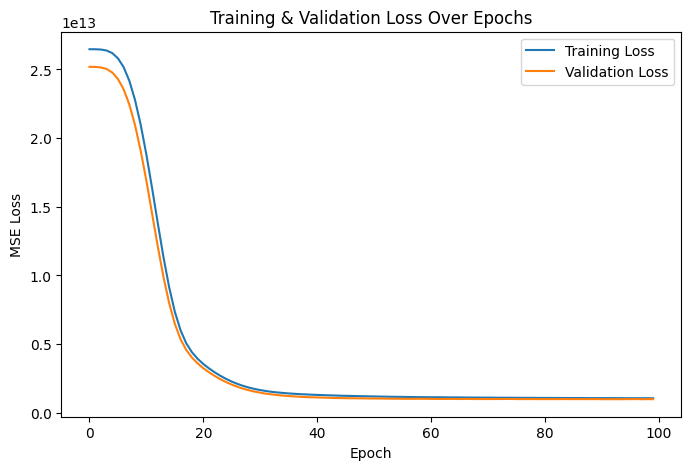


Final Evaluation on Test Data:
MSE:      996577640448.00
RMSE:     998287.38
R^2:      0.6541


In [13]:
#Problem 2B
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import time

# ------------------------------------------
# DEVICE SETUP
# ------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# ------------------------------------------
# LOAD & PREPARE DATA
# ------------------------------------------
data_url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv"
housing_df = pd.read_csv(data_url)

# Convert 'yes'/'no' columns to 1/0
bool_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                'airconditioning', 'prefarea']
housing_df[bool_columns] = housing_df[bool_columns].apply(lambda col: col.map({'yes': 1, 'no': 0}))

# Specify categorical columns for one-hot encoding
cat_cols = ['furnishingstatus']

# One-Hot Encoder setup (dropping first category to avoid dummy trap)
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = ohe.fit_transform(housing_df[cat_cols])

# Create a DataFrame from the encoded array
encoded_cols = ohe.get_feature_names_out(cat_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)

# Drop the original categorical column and concatenate the new columns
housing_df.drop(columns=cat_cols, inplace=True)
housing_df = pd.concat([housing_df, encoded_df], axis=1)

# Separate features (X) and target (y)
X_full = housing_df.drop(columns=['price'])
y_full = housing_df['price']

# ------------------------------------------
# TRAIN / TEST SPLIT
# ------------------------------------------
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_full,
    y_full,
    train_size=0.8,
    test_size=0.2,
    random_state=0
)

# ------------------------------------------
# STANDARDIZATION
# ------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_raw.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_raw.values, dtype=torch.float32).view(-1, 1).to(device)

# ------------------------------------------
# DATA LOADERS
# ------------------------------------------
batch_size = 4
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# ------------------------------------------
# DEFINE MLP MODEL
# ------------------------------------------
class RegressorNet(nn.Module):
    """
    A multi-layer perceptron for housing price regression.
    """
    def __init__(self, in_features):
        super(RegressorNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Single output neuron for regression
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
input_dim = X_train_scaled.shape[1]
model = RegressorNet(input_dim).to(device)

# ------------------------------------------
# TRAINING SETUP
# ------------------------------------------
mse_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_loss_log = []
val_loss_log = []

# ------------------------------------------
# TRAINING LOOP
# ------------------------------------------
start_time = time.time()

for ep in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        preds = model(batch_features)
        loss_val = mse_criterion(preds, batch_targets)
        loss_val.backward()
        optimizer.step()
        epoch_loss += loss_val.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_loss_log.append(avg_train_loss)

    # Validation step (using the test set)
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = mse_criterion(val_preds, y_test_tensor).item()
    val_loss_log.append(val_loss)

    if (ep + 1) % 10 == 0 or (ep + 1) == num_epochs:
        print(f"Epoch [{ep+1}/{num_epochs}] -> "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time):.2f} seconds.")

# ------------------------------------------
# PLOT LOSS CURVES
# ------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), train_loss_log, label="Training Loss")
plt.plot(range(num_epochs), val_loss_log, label="Validation Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# ------------------------------------------
# FINAL EVALUATION
# ------------------------------------------
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).cpu().numpy().flatten()
    test_targets = y_test_tensor.cpu().numpy().flatten()

mse_value = np.mean((test_predictions - test_targets) ** 2)
rmse_value = np.sqrt(mse_value)
r2_score_val = 1 - (np.sum((test_targets - test_predictions) ** 2) /
                    np.sum((test_targets - np.mean(test_targets)) ** 2))

print("\nFinal Evaluation on Test Data:")
print(f"MSE:      {mse_value:.2f}")
print(f"RMSE:     {rmse_value:.2f}")
print(f"R^2:      {r2_score_val:.4f}")


Using device: cuda
Epoch [1/100] Train Loss: 26469953478580.8438, Val Loss: 25189085609984.0000
Epoch [11/100] Train Loss: 19378701204301.5039, Val Loss: 16768827392000.0000
Epoch [21/100] Train Loss: 4870182754022.1650, Val Loss: 2834907267072.0000
Epoch [31/100] Train Loss: 2598960254637.7983, Val Loss: 1326998880256.0000
Epoch [41/100] Train Loss: 2288401849804.3301, Val Loss: 1131991924736.0000
Epoch [51/100] Train Loss: 1920095231173.2844, Val Loss: 1082281623552.0000
Epoch [61/100] Train Loss: 1938440992185.5413, Val Loss: 1172964900864.0000
Epoch [71/100] Train Loss: 1932442693068.3303, Val Loss: 1175883612160.0000
Epoch [81/100] Train Loss: 2017298484458.8623, Val Loss: 1409127809024.0000
Epoch [91/100] Train Loss: 1935988193655.7798, Val Loss: 1174771597312.0000
Epoch [100/100] Train Loss: 2111152338774.8992, Val Loss: 1025979842560.0000

Training completed in 14.36 seconds.


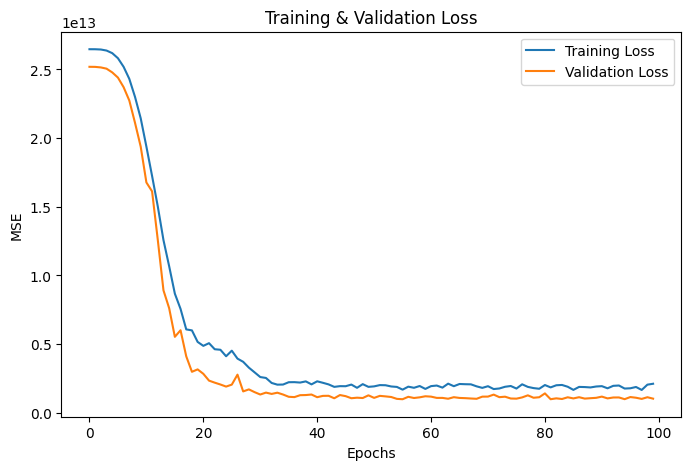


Final Model Performance:
MSE: 1025979908096.00
RMSE: 1012906.69
R² Score: 0.6439


In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import time

# -------------------------------------------
# DEVICE CONFIGURATION
# -------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------------------
# LOAD DATA
# -------------------------------------------
data_url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv'
df_housing = pd.read_csv(data_url)

# -------------------------------------------
# PREPROCESSING
# -------------------------------------------
# Convert yes/no columns to 1/0
binary_cols = ['mainroad', 'guestroom', 'basement',
               'hotwaterheating', 'airconditioning', 'prefarea']
df_housing[binary_cols] = df_housing[binary_cols].apply(lambda c: c.map({'yes': 1, 'no': 0}))

# One-Hot Encoding
cat_columns = ['furnishingstatus']  # Adjust as needed
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_vals = ohe.fit_transform(df_housing[cat_columns])

# Convert encoded values to a DataFrame
encoded_cols = ohe.get_feature_names_out(cat_columns)
encoded_df = pd.DataFrame(encoded_vals, columns=encoded_cols)

# Concatenate encoded columns and drop original categorical columns
df_housing.drop(columns=cat_columns, inplace=True)
df_housing = pd.concat([df_housing, encoded_df], axis=1)

# Separate features (X) and target (y)
X_data = df_housing.drop(columns=['price'])
y_data = df_housing['price']

# -------------------------------------------
# SPLIT INTO TRAIN & TEST
# -------------------------------------------
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_data, y_data, train_size=0.8, test_size=0.2, random_state=0
)

# -------------------------------------------
# SCALING
# -------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# -------------------------------------------
# TENSOR CONVERSION
# -------------------------------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_raw.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test_raw.values, dtype=torch.float32).view(-1, 1).to(device)

# -------------------------------------------
# DATALOADERS
# -------------------------------------------
batch_sz = 4
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_sz, shuffle=False)

# -------------------------------------------
# MODEL DEFINITION
# -------------------------------------------
class HouseRegressorNN(nn.Module):
    def __init__(self, n_inputs):
        super(HouseRegressorNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
input_dim = X_train_scaled.shape[1]
model = HouseRegressorNN(input_dim).to(device)

# -------------------------------------------
# TRAINING SETUP
# -------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_log = []
valid_log = []

# -------------------------------------------
# TRAINING LOOP
# -------------------------------------------
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_feats, batch_prices in train_loader:
        optimizer.zero_grad()
        preds = model(batch_feats)
        loss_val = criterion(preds, batch_prices)
        loss_val.backward()
        optimizer.step()
        epoch_loss += loss_val.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_log.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_t)
        val_loss = criterion(val_preds, y_test_t).item()
    valid_log.append(val_loss)

    # Print progress
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}")

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")

# -------------------------------------------
# PLOT TRAIN & VALIDATION LOSS
# -------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), train_log, label="Training Loss")
plt.plot(range(num_epochs), valid_log, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# -------------------------------------------
# FINAL EVALUATION
# -------------------------------------------
model.eval()
with torch.no_grad():
    test_output = model(X_test_t)

pred_vals = test_output.cpu().numpy().flatten()
true_vals = y_test_t.cpu().numpy().flatten()

mse_val = np.mean((pred_vals - true_vals) ** 2)
rmse_val = np.sqrt(mse_val)
r2_val = 1 - (np.sum((true_vals - pred_vals) ** 2) /
              np.sum((true_vals - np.mean(true_vals)) ** 2))

print("\nFinal Model Performance:")
print(f"MSE: {mse_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R² Score: {r2_val:.4f}")
